<a href="https://colab.research.google.com/github/Boamah-Powers/ml-learning/blob/main/neural_nets_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Neural Nets

Experimenting with neural nets

## Import relevant modules

In [1]:
# imports relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

# Adjust the granularity of reporting
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Imported modules")

Imported modules


## Loading dataset


In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the examples
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
7070,-118.3,34.1,30.0,1871.0,766.0,2595.0,819.0,2.0,212500.0
10048,-119.8,36.8,52.0,2408.0,498.0,1361.0,465.0,2.1,61300.0
5354,-118.2,34.1,52.0,1000.0,192.0,363.0,158.0,4.3,352800.0
10960,-120.9,35.4,29.0,2046.0,588.0,846.0,410.0,1.6,227300.0
15766,-122.4,37.8,52.0,1999.0,642.0,1846.0,620.0,1.9,225000.0


## Represent data

The following code cell creates preprocessing layers

In [3]:
# Keras Input tensors of float values
inputs = {
    'latitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='latitude'),
    'longitude':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='longitude'),
    'median_income':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='median_income'),
    'population':
        tf.keras.layers.Input(shape=(1,), dtype=tf.float32, name='population'),
}

# Create a Normalization layer to normalize the median_income data
median_income = tf.keras.layers.Normalization(
    name='normalization_median_income',
    axis=None
)
median_income.adapt(train_df['median_income'])
median_income = median_income(inputs.get('median_income'))

# Create a Normalization layer to normalize the population data
population = tf.keras.layers.Normalization(
    name='normalization_population',
    axis=None,
)
population.adapt(train_df['population'])
population = population(inputs.get('population'))

# Create a list of numbers representing the bucket boundaries for latitude
latitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the latitude data
latitude = tf.keras.layers.Normalization(
    name='normalization_latitude',
    axis=None
)
latitude.adapt(train_df['latitude'])
latitude = latitude(inputs.get('latitude'))

# Create a Discretization layer to separate the latitude data into buckets
latitude = tf.keras.layers.Discretization(
    bin_boundaries=latitude_boundaries,
    name='discretization_latitude'
)(latitude)

# Create a list of numbers representing the bucket boundaries for longitude
longitude_boundaries = np.linspace(-3, 3, 20+1)

# Create a Normalization layer to normalize the longitude data
longitude = tf.keras.layers.Normalization(
    name='normalization_longitude',
    axis=None,
)
longitude.adapt(train_df['longitude'])
longitude = longitude(inputs.get('longitude'))

# Create a Discretization layer to separate the longitude data into buckets
longitude = tf.keras.layers.Discretization(
    bin_boundaries=longitude_boundaries,
    name='discretization_longitude'
)(longitude)

# Cross the latitude and longitude features into a single one-hot vector
feature_cross = tf.keras.layers.HashedCrossing(
    num_bins=len(latitude_boundaries) * len(longitude_boundaries),
    output_mode='one_hot',
    name='cross_latitude_longitude'
)([latitude, longitude])

# Concatenate our inputs into a single vector
preprocessing_layers = tf.keras.layers.Concatenate()(
    [feature_cross, median_income, population]
)

print("Preprocessing layers defined.")


Preprocessing layers defined.


## Define the plotting function

In [4]:
# Define the plotting function

def plot_the_loss_curve(epochs, mse_training, mse_validation):
  """ Plot a curve of loss vs epoch """

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Mean Squared Error")

  plt.plot(epochs, mse_training, label="Training Loss")
  plt.plot(epochs, mse_validation, label="Validation Loss")

  # mse_training is a pandas Series, so convert it to a list first
  merged_mse_lists = mse_training.tolist() + mse_validation
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  top_of_y_axis = highest_loss * 1.03
  bottom_of_y_axis = lowest_loss * 0.97

  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.legend()
  plt.show()

print("Defined the plot_the_loss_curve function")

Defined the plot_the_loss_curve function


## Define functions to create and train a linear regression model

In [5]:
# Define functions to create and train a linear regression model
def create_model(my_inputs, my_outputs, my_learning_rate):
  """ Create and compile a simple linear regression model """
  model = tf.keras.Model(inputs=my_inputs, outputs=my_outputs)

  # Construct the layers into a model that Tensorflow can execute
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
      loss="mean_squared_error",
      metrics=[tf.keras.metrics.MeanSquaredError()],
  )

  return model

def train_model(model, dataset, epochs, batch_size, label_name, validation_split=0.1):
  """ Feed a dataset into the model in order to train it """

  # Split the dataset into features and label
  features = {name:np.array(value) for name, value in dataset.items()}
  label = train_median_house_value_normalized(np.array(features.pop(label_name)))
  history = model.fit(x=features, y=label, batch_size=batch_size, epochs=epochs,
                      shuffle=True, validation_split=validation_split)

  # Get details that will be useful for plotting the loss curve
  epochs = history.epoch
  hist = pd.DataFrame(history.history)
  mse = hist["mean_squared_error"]

  return epochs, mse, history.history

print("Defined the create_model and train_model functions")


Defined the create_model and train_model functions


## Define normalized label columns

In [6]:
# Create Normalization layers to normalize the median_house_value data

train_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
train_median_house_value_normalized.adapt(np.array(train_df['median_house_value']))

test_median_house_value_normalized = tf.keras.layers.Normalization(axis=None)
test_median_house_value_normalized.adapt(np.array(test_df['median_house_value']))

## Define linear regression model outputs

In [8]:
# Define linear regression model outputs
def get_outputs_linear_regression():
  # Create the Dense output layer
  dense_output = tf.keras.layers.Dense(units=1, name='dense_output')(preprocessing_layers)

  # Define an output dictionary we'll send to the model constructor
  outputs = {
      'dense_output': dense_output
  }

  return outputs

## Training the linear regression model

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 1s 29ms/step - loss: 0.9694 - mean_squared_error: 0.9694 - val_loss: 0.8002 - val_mean_squared_error: 0.8002
Epoch 2/15
14/14 [==============================] - 0s 9ms/step - loss: 0.6986 - mean_squared_error: 0.6986 - val_loss: 0.5864 - val_mean_squared_error: 0.5864
Epoch 3/15
14/14 [==============================] - 0s 10ms/step - loss: 0.5270 - mean_squared_error: 0.5270 - val_loss: 0.4554 - val_mean_squared_error: 0.4554
Epoch 4/15
14/14 [==============================] - 0s 8ms/step - loss: 0.4281 - mean_squared_error: 0.4281 - val_loss: 0.3868 - val_mean_squared_error: 0.3868
Epoch 5/15
14/14 [==============================] - 0s 9ms/step - loss: 0.3771 - mean_squared_error: 0.3771 - val_loss: 0.3554 - val_mean_squared_error: 0.3554
Epoch 6/15
14/14 [==============================] - 0s 9ms/step - loss: 0.3550 - mean_squared_error: 0.3550 - val_loss: 0.3421 - val_mean_squared_error: 0.3421
Epoch 7/15
14/14 [==============================]

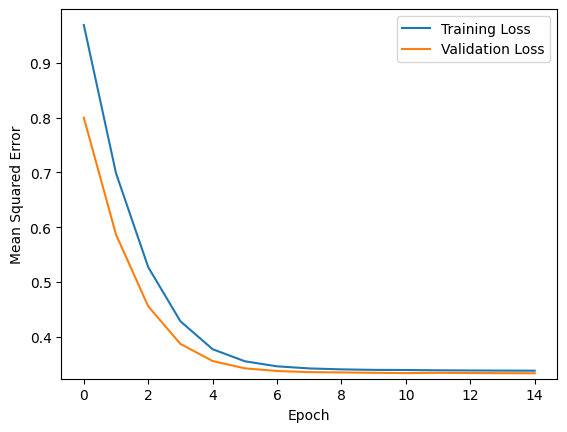


 Evaluate the linear regression model against the test set: 
3/3 [==============================] - 0s 8ms/step - loss: 0.3616 - mean_squared_error: 0.3616


{'loss': 0.36159929633140564, 'mean_squared_error': 0.36159929633140564}

In [9]:
# The following variables are the hyperparameters
learning_rate = 0.01
epochs = 15
batch_size = 1000
label_name = "median_house_value"

# Split the original training set into a reduced training set and a validation set
validation_split = 0.2

outputs = get_outputs_linear_regression()

# Establish the model's topography
my_model = create_model(inputs, outputs, learning_rate)

# Train the model on the normalized training set
epochs, mse, history = train_model(my_model, train_df, epochs, batch_size,
                                   label_name, validation_split)
plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(test_features.pop(label_name))
print("\n Evaluate the linear regression model against the test set: ")
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size, return_dict=True)

## Define a deep neural net model

In [14]:
# defines the topography of the deep neural net
def get_outputs_dnn():
  # Create a Dense layer with 20 nodes
  dense_output = tf.keras.layers.Dense(
      units = 10,
      activation='relu',
      name='hideen_dense_layer_1'
  )(preprocessing_layers)

  # Create a Dense layer with 12 nodes
  dense_output = tf.keras.layers.Dense(
      units=6,
      activation='relu',
      name='hidden_dense_layer_2'
  )(dense_output)

  # Create the Dense output layer
  dense_output = tf.keras.layers.Dense(
      units=1,
      name='dense_output'
  )(dense_output)

  # Defina an output dictionary we'll send to the model constructor
  outputs = {
      'dense_output': dense_output
  }

  return outputs

## Training the deep neural net

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['housing_median_age', 'total_rooms', 'total_bedrooms', 'households'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


14/14 [==============================] - 1s 30ms/step - loss: 0.6735 - mean_squared_error: 0.6735 - val_loss: 0.3824 - val_mean_squared_error: 0.3824
Epoch 2/20
14/14 [==============================] - 0s 13ms/step - loss: 0.3741 - mean_squared_error: 0.3741 - val_loss: 0.3431 - val_mean_squared_error: 0.3431
Epoch 3/20
14/14 [==============================] - 0s 11ms/step - loss: 0.3392 - mean_squared_error: 0.3392 - val_loss: 0.3341 - val_mean_squared_error: 0.3341
Epoch 4/20
14/14 [==============================] - 0s 11ms/step - loss: 0.3300 - mean_squared_error: 0.3300 - val_loss: 0.3264 - val_mean_squared_error: 0.3264
Epoch 5/20
14/14 [==============================] - 0s 11ms/step - loss: 0.3249 - mean_squared_error: 0.3249 - val_loss: 0.3251 - val_mean_squared_error: 0.3251
Epoch 6/20
14/14 [==============================] - 0s 11ms/step - loss: 0.3238 - mean_squared_error: 0.3238 - val_loss: 0.3220 - val_mean_squared_error: 0.3220
Epoch 7/20
14/14 [===========================

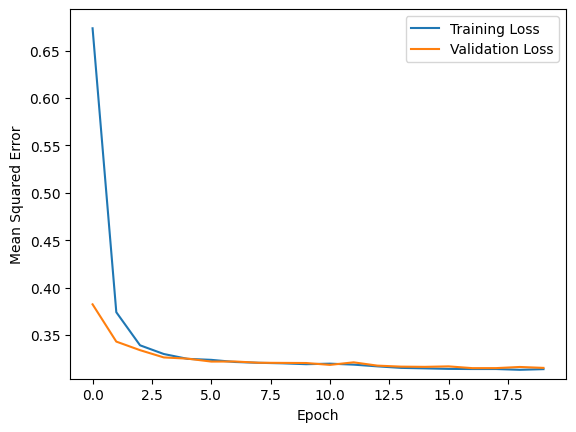


 Evaluate the new model against the test set: 
3/3 [==============================] - 0s 10ms/step - loss: 0.3459 - mean_squared_error: 0.3459


{'loss': 0.3458573818206787, 'mean_squared_error': 0.3458573818206787}

In [15]:
# The following variables are the hyperparameters
learning_rate = 0.01
epochs = 20
batch_size = 1000

# Specify the label
label_name = "median_house_value"

# Split the original training set into a reduced set and
# a validation set
validation_split = 0.2

dnn_outputs = get_outputs_dnn()

# Establish the model's topography
my_model = create_model(
    inputs,
    dnn_outputs,
    learning_rate
)

# Train the model on the normalized training set
epochs, mse, history = train_model(
    my_model,
    train_df,
    epochs,
    batch_size,
    label_name,
    validation_split,
)

plot_the_loss_curve(epochs, mse, history["val_mean_squared_error"])

# Testing the model against the test set
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = test_median_house_value_normalized(np.array(test_features.pop(label_name)))
print("\n Evaluate the new model against the test set: ")
my_model.evaluate(
    x=test_features,
    y=test_label,
    batch_size=batch_size,
    return_dict=True
)